# Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import yahoo_fin.stock_info as si

from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error  
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Downloading Stock Price Data

In [2]:
# from stockprice.py
def create_data(ticker, start = "2021-01-04"):
    company = si.get_data(ticker)
    company = company.loc[start:] # 01-04 is the first Monday of 2021.
    company["date"] = company.index
    company = company.reset_index()
    company.drop(columns = "index", inplace = True)
    return company

In [152]:
df = create_data("SBUX")
df

,open,high,low,close,adjclose,volume,ticker,date
0,107.660004,107.750000,102.139999,103.099998,97.033073,8041500,SBUX,2021-01-04
1,102.919998,104.260002,102.800003,103.440002,97.353065,5721900,SBUX,2021-01-05
2,102.989998,105.209999,102.910004,104.190002,98.058929,5017200,SBUX,2021-01-06
3,104.489998,104.639999,102.949997,103.349998,97.268364,5057000,SBUX,2021-01-07
4,103.860001,105.760002,103.419998,105.669998,99.451836,5869700,SBUX,2021-01-08
...,...,...,...,...,...,...,...,...
731,101.510002,101.690002,99.529999,99.849998,99.849998,8428500,SBUX,2023-11-29
732,100.059998,100.120003,98.419998,99.300003,99.300003,11442600,SBUX,2023-11-30
733,98.500000,99.279999,97.519997,99.199997,99.199997,12503900,SBUX,2023-12-01
734,98.389999,98.879997,96.769997,97.599998,97.599998,11477400,SBUX,2023-12-04


# Cleaning Data

In [148]:
def clean_data(data):
    return data.dropna(ignore_index = True)

# Adding Features

In [151]:
def add_features(data):
    
    # add column for quarterly months: 3,6,9,12
    split_date = data["date"].astype(str).str.split("-", expand = True) # year, month, day
    data["month"] = split_date[1].astype("int")
    data["day"] = split_date[2].astype("int")
    data["year"] = split_date[0].astype("int")
    data["quarterly"] = np.where(df['month']%3==0,1,0) # identify end of quarter months
    
    # add open-close and low-high columns
    data["open-close"] = data["open"] - data["close"]
    data["low-high"] = data["low"] - data["high"]
    
    # add Estimated Moving Average using time window of 100 days
    data['EMA100'] = df['close'].ewm(span=100, adjust=False).mean()
    
    # add Bollinger Bands
    data['MA20'] = data['close'].rolling(window=20).mean() # moving average for 20 day period
    data['MA20dSTD'] = data['close'].rolling(window=20).std() # moving average standard deviation for 20 day period
    data['Bollinger_Upper'] = data['MA20'] + (data['MA20dSTD'] * 2)
    data['Bollinger_Lower'] = data['MA20'] - (data['MA20dSTD'] * 2)
    
    # set date as index
    data.date = pd.to_datetime(data.date)
    data.set_index('date', inplace=True)
    
    # replace Nans
    na_replace = data.at[data.index.max(), 'close']    
    df.fillna((na_replace), inplace=True)
    
    return data

In [153]:
df = clean_data(df)
df = add_features(df)
df

,open,high,low,close,adjclose,volume,ticker,month,day,year,quarterly,open-close,low-high,EMA100,MA20,MA20dSTD,Bollinger_Upper,Bollinger_Lower
date,,,,,,,,,,,,,,,,,,
2021-01-04,107.660004,107.750000,102.139999,103.099998,97.033073,8041500,SBUX,1,4,2021,0,4.560005,-5.610001,103.099998,95.540001,95.540001,95.540001,95.540001
2021-01-05,102.919998,104.260002,102.800003,103.440002,97.353065,5721900,SBUX,1,5,2021,0,-0.520004,-1.459999,103.106731,95.540001,95.540001,95.540001,95.540001
2021-01-06,102.989998,105.209999,102.910004,104.190002,98.058929,5017200,SBUX,1,6,2021,0,-1.200005,-2.299995,103.128182,95.540001,95.540001,95.540001,95.540001
2021-01-07,104.489998,104.639999,102.949997,103.349998,97.268364,5057000,SBUX,1,7,2021,0,1.139999,-1.690002,103.132575,95.540001,95.540001,95.540001,95.540001
2021-01-08,103.860001,105.760002,103.419998,105.669998,99.451836,5869700,SBUX,1,8,2021,0,-1.809998,-2.340004,103.182821,95.540001,95.540001,95.540001,95.540001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29,101.510002,101.690002,99.529999,99.849998,99.849998,8428500,SBUX,11,29,2023,0,1.660004,-2.160004,98.645951,102.905001,3.298822,109.502645,96.307356
2023-11-30,100.059998,100.120003,98.419998,99.300003,99.300003,11442600,SBUX,11,30,2023,0,0.759995,-1.700005,98.658903,103.302501,2.091085,107.484672,99.120330
2023-12-01,98.500000,99.279999,97.519997,99.199997,99.199997,12503900,SBUX,12,1,2023,1,-0.699997,-1.760002,98.669617,103.262001,2.164757,107.591515,98.932486


# Splitting and Normalizing Data

In [118]:
def pred_target(features, dataset):
    return dataset[features], dataset["close"]

## Normalizing Data

In [119]:
# should we create this function
def scalers(pred, target):
    # normalize between 0 and 1
    # define scalers
    scaler_pred = MinMaxScaler() # for scaling multiple columns
    scaler_target = MinMaxScaler() # for scaling one column
    # scale data
    scaled_pred = scaler_pred.fit_transform(pred.values)
    scaled_target = scaler_target.fit_transform(target.values.reshape(-1,1))
    return scaler_pred, scaler_target, scaled_pred, scaled_target

In [155]:
# keep features columns
features = ["close", "open", "Bollinger_Upper", "Bollinger_Lower", "EMA100"]
df_feat_pred, df_close_target = pred_target(features, df) # predictor and target data
df_feat_pred.head(), df_close_target.head()

(                 close        open  Bollinger_Upper  Bollinger_Lower  \
 date                                                                   
 2021-01-04  103.099998  107.660004        95.540001        95.540001   
 2021-01-05  103.440002  102.919998        95.540001        95.540001   
 2021-01-06  104.190002  102.989998        95.540001        95.540001   
 2021-01-07  103.349998  104.489998        95.540001        95.540001   
 2021-01-08  105.669998  103.860001        95.540001        95.540001   
 
                 EMA100  
 date                    
 2021-01-04  103.099998  
 2021-01-05  103.106731  
 2021-01-06  103.128182  
 2021-01-07  103.132575  
 2021-01-08  103.182821  ,
 date
 2021-01-04    103.099998
 2021-01-05    103.440002
 2021-01-06    104.190002
 2021-01-07    103.349998
 2021-01-08    105.669998
 Name: close, dtype: float64)

In [156]:
scaler_pred, scaler_target, scaled_pred, scaled_target = scalers(df_feat_pred, df_close_target)

In [157]:
scaled_pred.shape, scaled_target.shape

((736, 5), (736, 1))

## Splitting Data

In [124]:
def train_val_test(pred, seq_len):
    
    # split data into training, validation, and testing data
    train_len = int(0.7*len(pred))
    val_len = int(0.2*train_len) # validations set is 20% of training set
    
    val_data = scaled_pred[:val_len,:]
    train_data = scaled_pred[val_len:train_len, :]
    test_data = scaled_pred[train_len - seq_len:, :]
    
    return train_data, val_data, test_data

In [125]:
def split_data(seq_len, data, index_close):
    x, y = [], []
    data_len = data.shape[0]

    for i in range(seq_len, data_len):
        x.append(data[i-seq_len:i,:]) # previous 50 day values
        y.append(data[i, index_close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [158]:
seq_len = 50
index_close = df_feat_pred.columns.get_loc("close")
train_data, val_data, test_data = train_val_test(df_feat_pred, 50)
x_train, y_train = split_data(seq_len, train_data, index_close)
x_val, y_val = split_data(seq_len, val_data, index_close)
x_test, y_test = split_data(seq_len, test_data, index_close)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(True if x_train[1][seq_len-1][0] == y_train[0] else False)

(362, 50, 5) (362,)
(53, 50, 5) (53,)
(221, 50, 5) (221,)
True


# Model

In [159]:
model = Sequential()
n_neurons = x_train.shape[1] * x_train.shape[2]
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5)) # for 6 features besides close - best
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train Model
callback = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size = 16, 
                    epochs = 50,
                    callbacks = [callback],
                    validation_data=(x_val, y_val)
                   )

Epoch 1/50
23/23 [==============================] - 4s 121ms/step - loss: 0.0362 - val_loss: 0.0109
Epoch 2/50
23/23 [==============================] - 2s 108ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 3/50
23/23 [==============================] - 2s 105ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 4/50
23/23 [==============================] - 2s 106ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 5/50
23/23 [==============================] - 2s 106ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 6/50
23/23 [==============================] - 3s 109ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 7/50
23/23 [==============================] - 3s 110ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 8/50
23/23 [==============================] - 2s 108ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 9/50
23/23 [==============================] - 2s 107ms/step - loss: 0.0036 - val_loss: 0.0058
Epoch 10/50
23/23 [==============================] - 2s 107ms/step - loss: 0.0032 - val_loss: 0.0021

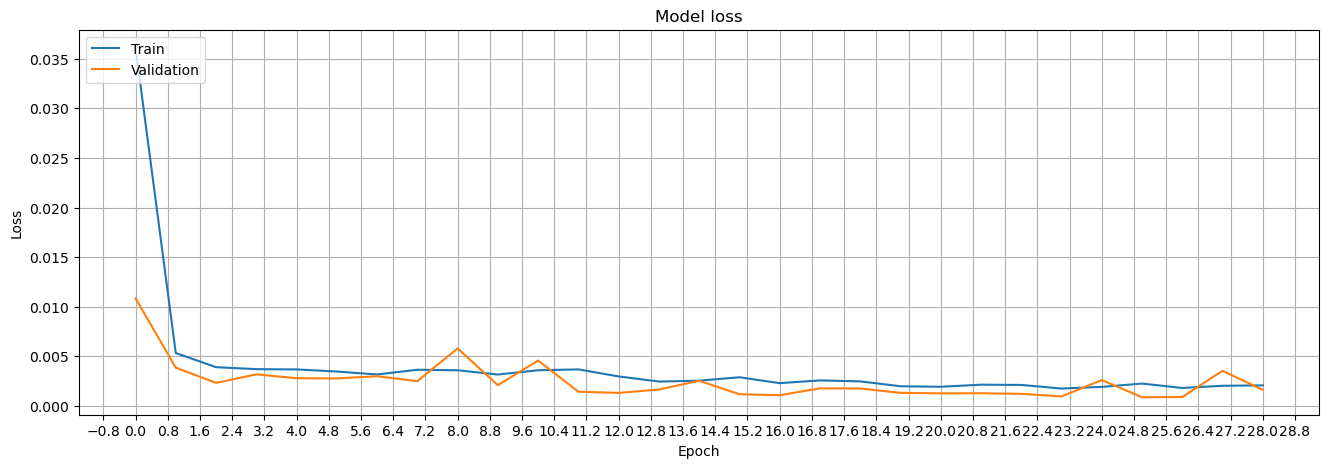

In [160]:
fig, ax = plt.subplots(figsize=(16, 5))

# Plot training loss
ax.plot(history.history["loss"], label="Train")

if 'val_loss' in history.history:
    ax.plot(history.history["val_loss"], label="Validation")

ax.set_title("Model loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(50))
ax.legend(loc="upper left")
ax.grid()
plt.show()

7/7 [==============================] - 1s 60ms/step


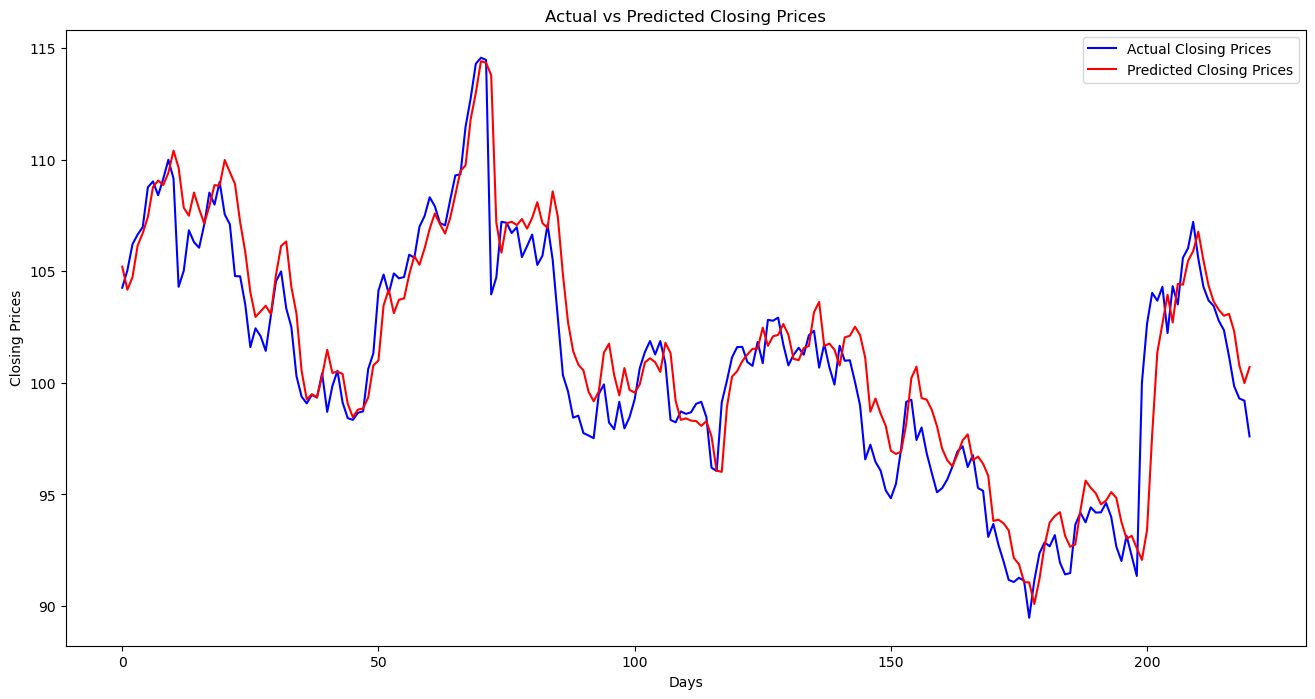

Median Absolute Error (MAE): 1.4
Mean Absolute Percentage Error (MAPE): 1.39 %
Median Absolute Percentage Error (MDAPE): 1.09 %


In [40]:
# Evaluate Model Performance

y_predicted_close = model.predict(x_test) # predict closing prices
y_predicted_close = scaler_target.inverse_transform(y_predicted_close) # unscale predictions
y_true_close = scaler_target.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(16, 8))
plt.plot(y_true_close, label='Actual Closing Prices', color='blue')
plt.plot(y_predicted_close, label='Predicted Closing Prices', color='red')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.legend()
plt.show()

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_true_close, y_predicted_close)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_true_close, y_predicted_close)/ y_true_close))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_true_close, y_predicted_close)/ y_true_close)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

7/7 [==============================] - 0s 45ms/step


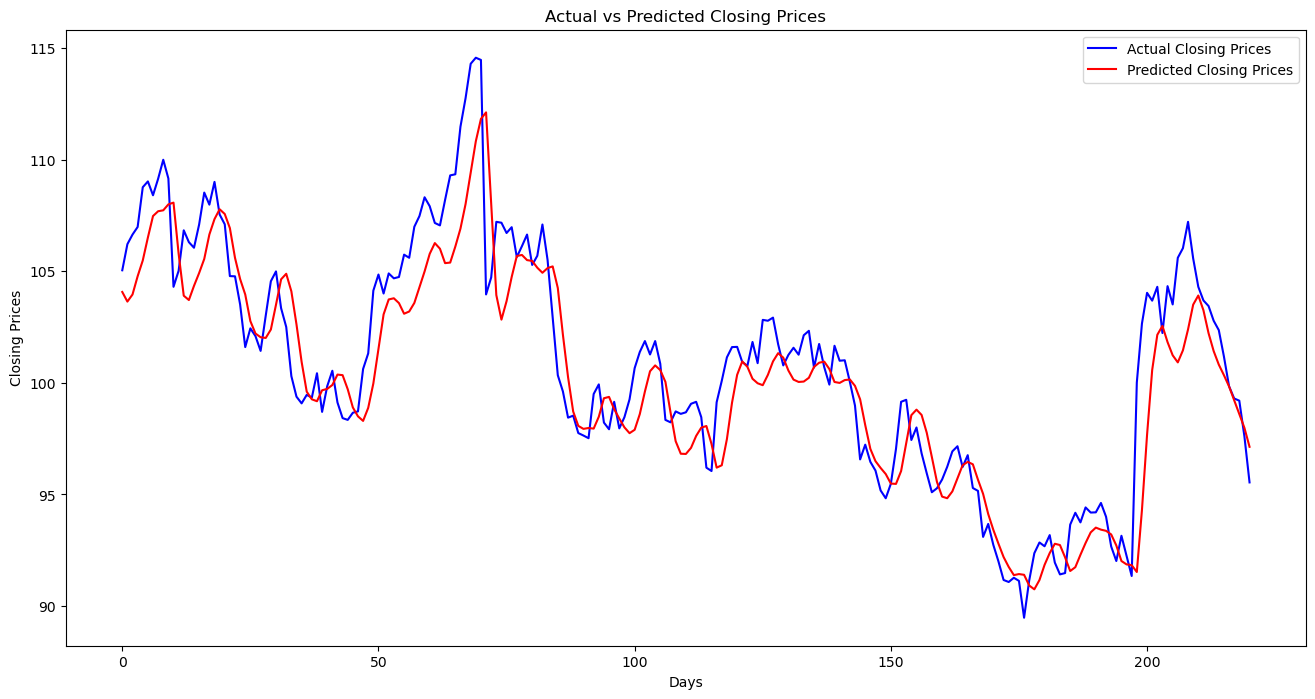

Median Absolute Error (MAE): 1.66
Mean Absolute Percentage Error (MAPE): 1.62 %
Median Absolute Percentage Error (MDAPE): 1.33 %


In [163]:
# Evaluate Model Performance

y_predicted_close = model.predict(x_test) # predict closing prices
y_predicted_close = scaler_target.inverse_transform(y_predicted_close) # unscale predictions
y_true_close= scaler_target.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(16, 8))
plt.plot(y_true_close, label='Actual Closing Prices', color='blue')
plt.plot(y_predicted_close, label='Predicted Closing Prices', color='red')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.legend()
plt.show()

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_true_close, y_predicted_close)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_true_close, y_predicted_close)/ y_true_close))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_true_close, y_predicted_close)/ y_true_close)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')